**Name:** Kranti Adsul

**USC ID:** 5747073786

# EE 641, Fall 2023 - Homework #1
## Region-based convolutional neural networks (R-CNN)

### Overview

Fine-tune a PyTorch R-CNN model to extract text from natural scenes (see figure below).  Given a scene input your model should output a list of bounding boxes corresponding to each text region.  

Prepare:
  1. validation figures that show machine-predicted bounding boxes vs. the ground-truth boxes
  1. loss-curves that show component-wise R-CNN losses as a function of epoch

![Text regions](attachment:4_images_with_boxes_and_text-2.png)

### Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/mscoco_text_cleaned_v01.zip' -d '/content/drive/MyDrive/'

Streaming output truncated to the last 5000 lines.
  inflating: /content/drive/MyDrive/data/train/COCO_train2014_000000435897.jpg  
  inflating: /content/drive/MyDrive/data/train/COCO_train2014_000000436161.jpg  
  inflating: /content/drive/MyDrive/data/train/COCO_train2014_000000437605.jpg  
  inflating: /content/drive/MyDrive/data/train/COCO_train2014_000000437849.jpg  
  inflating: /content/drive/MyDrive/data/train/COCO_train2014_000000439268.jpg  
  inflating: /content/drive/MyDrive/data/train/COCO_train2014_000000440792.jpg  
  inflating: /content/drive/MyDrive/data/train/COCO_train2014_000000441850.jpg  
  inflating: /content/drive/MyDrive/data/train/COCO_train2014_000000442911.jpg  
  inflating: /content/drive/MyDrive/data/train/COCO_train2014_000000443209.jpg  
  inflating: /content/drive/MyDrive/data/train/COCO_train2014_000000443390.jpg  
  inflating: /content/drive/MyDrive/data/train/COCO_train2014_000000443941.jpg  
  inflating: /content/drive/MyDrive/data/train/COCO_train2

In [ ]:
# Remove the ZIP file (cleanup)
!rm '/content/drive/MyDrive/mscoco_text_cleaned_v01.zip'

In [ ]:
!pip install requests

In [ ]:
import requests

# URL of the file to download
url = "https://data.usc-ece.com/EE641/HW1/COCO_Text.json"

# Specify the local file path where you want to save the downloaded file
local_file_path = "/content/COCO_Text.json"  # You can change this path as needed

# Send an HTTP GET request to the URL
response = requests.get(url)

# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Open the local file in binary write mode and write the content from the response
    with open(local_file_path, 'wb') as file:
        file.write(response.content)
    print("File downloaded successfully.")
else:
    print("Failed to download the file. Status code:", response.status_code)

File downloaded successfully.


## Helpers (Complete, but you may modify)

In [ ]:
#@title Imports
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch
import os
import cv2
import numpy as np
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead, RegionProposalNetwork
import torch
import shutil
import time

In [ ]:
#@title COCO_Text class: Handles the annotation file
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

__author__ = 'andreasveit'
__version__ = '1.1'
# Interface for accessing the COCO-Text dataset.

# COCO-Text is a large dataset designed for text detection and recognition.
# This is a Python API that assists in loading, parsing and visualizing the
# annotations. The format of the COCO-Text annotations is also described on
# the project website http://vision.cornell.edu/se3/coco-text/. In addition to this API, please download both
# the COCO images and annotations.
# This dataset is based on Microsoft COCO. Please visit http://mscoco.org/
# for more information on COCO, including for the image data, object annotatins
# and caption annotations.

# An alternative to using the API is to load the annotations directly
# into Python dictionary:
# with open(annotation_filename) as json_file:
#     coco_text = json.load(json_file)
# Using the API provides additional utility functions.

# The following API functions are defined:
#  COCO_Text  - COCO-Text api class that loads COCO annotations and prepare data structures.
#  getAnnIds  - Get ann ids that satisfy given filter conditions.
#  getImgIds  - Get img ids that satisfy given filter conditions.
#  loadAnns   - Load anns with the specified ids.
#  loadImgs   - Load imgs with the specified ids.
#  showAnns   - Display the specified annotations.
#  loadRes    - Load algorithm results and create API for accessing them.
# Throughout the API "ann"=annotation, "cat"=category, and "img"=image.

# COCO-Text Toolbox.        Version 1.1
# Data and  paper available at:  http://vision.cornell.edu/se3/coco-text/
# Code based on Microsoft COCO Toolbox Version 1.0 by Piotr Dollar and Tsung-Yi Lin
# extended and adapted by Andreas Veit, 2016.
# Licensed under the Simplified BSD License [see bsd.txt]

import json
import datetime
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle, PathPatch
from matplotlib.path import Path
import numpy as np
import copy
import os

class COCO_Text:
    def __init__(self, annotation_file="/content/COCO_Text.json"):
        """
        Constructor of COCO-Text helper class for reading and visualizing annotations.
        :param annotation_file (str): location of annotation file
        :return:
        """
        # load dataset
        self.dataset = {}
        self.anns = {}
        self.imgToAnns = {}
        self.catToImgs = {}
        self.imgs = {}
        self.cats = {}
        self.val = []
        self.test = []
        self.train = []
        if not annotation_file == None:
            assert os.path.isfile(annotation_file), "file does not exist"
            print('loading annotations into memory...')
            time_t = datetime.datetime.utcnow()
            dataset = json.load(open(annotation_file, 'r'))
            print(datetime.datetime.utcnow() - time_t)
            self.dataset = dataset
            self.createIndex()

    def createIndex(self):
        # create index
        print('creating index...')
        self.imgToAnns = {int(cocoid): self.dataset['imgToAnns'][cocoid] for cocoid in self.dataset['imgToAnns']}
        self.imgs      = {int(cocoid): self.dataset['imgs'][cocoid] for cocoid in self.dataset['imgs']}
        self.anns      = {int(annid): self.dataset['anns'][annid] for annid in self.dataset['anns']}
        self.cats      = self.dataset['cats']
        self.val       = [int(cocoid) for cocoid in self.dataset['imgs'] if self.dataset['imgs'][cocoid]['set'] == 'val']
        self.test      = [int(cocoid) for cocoid in self.dataset['imgs'] if self.dataset['imgs'][cocoid]['set'] == 'test']
        self.train     = [int(cocoid) for cocoid in self.dataset['imgs'] if self.dataset['imgs'][cocoid]['set'] == 'train']
        print('index created!')

    def info(self):
        """
        Print information about the annotation file.
        :return:
        """
        for key, value in self.dataset['info'].items():
            print('%s: %s'%(key, value))

    def filtering(self, filterDict, criteria):
        return [key for key in filterDict if all(criterion(filterDict[key]) for criterion in criteria)]

    def getAnnByCat(self, properties):
        """
        Get ann ids that satisfy given properties
        :param properties (list of tuples of the form [(category type, category)] e.g., [('readability','readable')]
            : get anns for given categories - anns have to satisfy all given property tuples
        :return: ids (int array)       : integer array of ann ids
        """
        return self.filtering(self.anns, [lambda d, x=a, y=b:d[x] == y for (a,b) in properties])

    def getAnnIds(self, imgIds=[], catIds=[], areaRng=[]):
        """
        Get ann ids that satisfy given filter conditions. default skips that filter
        :param imgIds  (int array)     : get anns for given imgs
               catIds  (list of tuples of the form [(category type, category)] e.g., [('readability','readable')]
                : get anns for given cats
               areaRng (float array)   : get anns for given area range (e.g. [0 inf])
        :return: ids (int array)       : integer array of ann ids
        """
        imgIds = imgIds if type(imgIds) == list else [imgIds]
        catIds = catIds if type(catIds) == list else [catIds]

        if len(imgIds) == len(catIds) == len(areaRng) == 0:
            anns = list(self.anns.keys())
        else:
            if not len(imgIds) == 0:
                anns = sum([self.imgToAnns[imgId] for imgId in imgIds if imgId in self.imgToAnns],[])
            else:
                anns = list(self.anns.keys())
            anns = anns if len(catIds)  == 0 else list(set(anns).intersection(set(self.getAnnByCat(catIds))))
            anns = anns if len(areaRng) == 0 else [ann for ann in anns if self.anns[ann]['area'] > areaRng[0] and self.anns[ann]['area'] < areaRng[1]]
        return anns

    def getImgIds(self, imgIds=[], catIds=[]):
        '''
        Get img ids that satisfy given filter conditions.
        :param imgIds (int array) : get imgs for given ids
        :param catIds (int array) : get imgs with all given cats
        :return: ids (int array)  : integer array of img ids
        '''
        imgIds = imgIds if type(imgIds) == list else [imgIds]
        catIds = catIds if type(catIds) == list else [catIds]

        if len(imgIds) == len(catIds) == 0:
            ids = list(self.imgs.keys())
        else:
            ids = set(imgIds)
            if not len(catIds) == 0:
                ids  = ids.intersection(set([self.anns[annid]['image_id'] for annid in self.getAnnByCat(catIds)]))
        return list(ids)

    def loadAnns(self, ids=[]):
        """
        Load anns with the specified ids.
        :param ids (int array)       : integer ids specifying anns
        :return: anns (object array) : loaded ann objects
        """
        if type(ids) == list:
            return [self.anns[id] for id in ids]
        elif type(ids) == int:
            return [self.anns[ids]]

    def loadImgs(self, ids=[]):
        """
        Load anns with the specified ids.
        :param ids (int array)       : integer ids specifying img
        :return: imgs (object array) : loaded img objects
        """
        if type(ids) == list:
            return [self.imgs[id] for id in ids]
        elif type(ids) == int:
            return [self.imgs[ids]]

    def showAnns(self, anns, show_polygon=False):
        """
        Display the specified annotations.
        :param anns (array of object): annotations to display
        :return: None
        """
        if len(anns) == 0:
            return 0
        ax = plt.gca()
        boxes = []
        color = []
        for ann in anns:
            c = np.random.random((1, 3)).tolist()[0]
            if show_polygon:
                tl_x, tl_y, tr_x, tr_y, br_x, br_y, bl_x, bl_y = ann['polygon']
                verts = [(tl_x, tl_y), (tr_x, tr_y), (br_x, br_y), (bl_x, bl_y), (0, 0)]
                codes = [Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO, Path.CLOSEPOLY]
                path = Path(verts, codes)
                patch = PathPatch(path, facecolor='none')
                boxes.append(patch)
                left, top = tl_x, tl_y
            else:
                left, top, width, height = ann['bbox']
                boxes.append(Rectangle([left,top],width,height,alpha=0.4))
            color.append(c)
            if 'utf8_string' in list(ann.keys()):
                ax.annotate(ann['utf8_string'],(left,top-4),color=c)
        p = PatchCollection(boxes, facecolors=color, edgecolors=(0,0,0,1), linewidths=3, alpha=0.4)
        ax.add_collection(p)

    def loadRes(self, resFile):
        """
        Load result file and return a result api object.
        :param   resFile (str)     : file name of result file
        :return: res (obj)         : result api object
        """
        res = COCO_Text()
        res.dataset['imgs'] = [img for img in self.dataset['imgs']]

        print('Loading and preparing results...     ')
        time_t = datetime.datetime.utcnow()
        if type(resFile) == str:
            anns = json.load(open(resFile))
        else:
            anns = resFile
        assert type(anns) == list, 'results in not an array of objects'
        annsImgIds = [int(ann['image_id']) for ann in anns]

        if set(annsImgIds) != (set(annsImgIds) & set(self.getImgIds())):
            print('Results do not correspond to current coco set')
            print('skipping ', str(len(set(annsImgIds)) - len(set(annsImgIds) & set(self.getImgIds()))), ' images')
        annsImgIds = list(set(annsImgIds) & set(self.getImgIds()))

        res.imgToAnns = {cocoid : [] for cocoid in annsImgIds}
        res.imgs = {cocoid: self.imgs[cocoid] for cocoid in annsImgIds}

        assert anns[0]['bbox'] != [], 'results have incorrect format'
        for id, ann in enumerate(anns):
            if ann['image_id'] not in annsImgIds:
                continue
            bb = ann['bbox']
            ann['area'] = bb[2]*bb[3]
            ann['id'] = id
            res.anns[id] = ann
            res.imgToAnns[ann['image_id']].append(id)
        print('DONE (t=%0.2fs)'%((datetime.datetime.utcnow() - time_t).total_seconds()))

        return res

### CocoDataset class (TODO)

TODO: `CocoDataset::__getitem__()`

In [ ]:
from PIL import Image
import os
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from pycocotools.coco import COCO
import numpy as np

class CocoDataset(Dataset):
    def __init__(self, root_dir, annFile, transform=None, cuda=True):
        self.root_dir = root_dir
        self.transform = transform
        self.imgs = os.listdir(root_dir)
        # annotations
        self.ct = COCO_Text(annFile)
        self.imgIds = self.ct.getImgIds(
            imgIds=self.ct.train,
            catIds=[('legibility', 'legible'), ('class', 'machine printed')]
        )

        for imgId in self.imgIds:
            file_name = self.ct.loadImgs(imgId)[0]['file_name']
            if file_name not in self.imgs:
                self.imgIds.remove(imgId)
        # manual exclude
        self.imgIds.remove(275939)
        self.imgIds.remove(443671)

        # remaining images
        print(f"remaining images in ann file: {len(self.imgIds)}, remaining images in folder: {len(self.imgs)}")

        self.imgIds.sort()
        # sort the images in the same order as the annotations
        self.imgs = [self.ct.loadImgs(imgId)[0]['file_name'] for imgId in self.imgIds]

        self.img_h = 224
        self.img_w = 224
        self.cuda = cuda

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Get the image ID at the specified index
        img_id = self.imgIds[idx]

        # Load the image corresponding to img_id
        img_info = self.ct.loadImgs(img_id)[0]
        img_path = os.path.join(self.root_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        # Resize the image to a common size (e.g., 224x224)
        target_size = (224, 224)  # Set your desired target size
        image = image.resize(target_size, Image.LANCZOS)

        # Apply transformations (if any) to the image
        if self.transform is not None:
            image = self.transform(image)

        # Convert the image to a tensor
        image = transforms.ToTensor()(image)

        # Retrieve annotations for the image
        ann_ids = self.ct.getAnnIds(imgIds=img_id)
        annotations = self.ct.loadAnns(ann_ids)

        # Resize the bounding box coordinates to match the resized image
        resized_annotations = []
        for ann in annotations:
            bbox = ann['bbox']
            x, y, width, height = bbox

            # Resize the coordinates based on the image's new dimensions
            x *= (target_size[0] / img_info['width'])
            y *= (target_size[1] / img_info['height'])
            width *= (target_size[0] / img_info['width'])
            height *= (target_size[1] / img_info['height'])

            # Append the resized bounding box to the list of annotations
            resized_annotations.append([x, y, x + width, y + height])

        # Convert bounding_boxes to a tensor
        bounding_boxes = torch.tensor(resized_annotations, dtype=torch.float32)

        # Create a dictionary containing the resized image and bounding boxes
        target = {
            "boxes": bounding_boxes,
            "labels": torch.ones(len(bounding_boxes), dtype=torch.int64),  # You can set labels accordingly
            "image_id": img_id,
        }

        return image, target


# collate_fn is used to collate the data into batches
def collate_fn(batch):
    images = []
    targets = []
    for item in batch:
        images.append(item[0])
        targets.append(item[1])
    images = torch.stack(images, 0)
    return images, targets

# Evaluate / region visualization (TODO)

Load four images and predict regions using model.
Create a figure that shows the images as subplots.
Overlay model predicted regions (blue) and target regions (red).
Save the output as an image -- use epoch in filename to preserve order.

In [ ]:
import random

def evaluate(model, dataloader, device, epoch):
    model.eval()

    # Initialize a counter for the number of images processed
    image_counter = 0

    for images, targets in dataloader:
        # Send images to the device (GPU or CPU)
        images = [image.to(device) for image in images]

        with torch.no_grad():
            predictions = model(images)

        # Loop through the batch of images
        for i, image in enumerate(images):
            image_counter += 1

            # Get the original image as a NumPy array (assuming it's in CPU)
            original_image = images[i].permute(1, 2, 0).cpu().numpy()

            # Get predicted boxes, scores, and labels for this image
            prediction = predictions[i]
            predicted_boxes = prediction['boxes'].cpu().numpy()
            predicted_scores = prediction['scores'].cpu().numpy()
            predicted_labels = prediction['labels'].cpu().numpy()

            # Retrieve the target boxes for this image
            target_boxes = targets[i]["boxes"].cpu().numpy()

            # Create a figure with subplots
            fig, ax = plt.subplots(figsize=(12, 6))

            # Show the original image
            ax.imshow(original_image)
            ax.set_title("Image")

            # Overlay predicted bounding boxes on the image in blue
            for box, score, label in zip(predicted_boxes, predicted_scores, predicted_labels):
                if score > 0.5:  # You can adjust the confidence threshold
                    x_min, y_min, x_max, y_max = box
                    rect = plt.Rectangle(
                        (x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='blue', linewidth=2
                    )
                    ax.add_patch(rect)
                    ax.text(x_min, y_min, f"Predicted: {label}, Score: {score:.2f}", color='blue')

            # Overlay target bounding boxes on the image in red
            for box in target_boxes:
                x_min, y_min, x_max, y_max = box
                rect = plt.Rectangle(
                    (x_min, y_min), x_max - x_min, y_max - y_min, fill=False, edgecolor='red', linewidth=2
                )
                ax.add_patch(rect)

            # Save the figure with the epoch and image counter in the filename
            plt.savefig(f"epoch_{epoch}_image_{image_counter}.png")
            plt.show()

            # Limit to processing four images
            if image_counter >= 4:
                return


# Model factory (TODO)

Use a pretrained torchvision model. Keep training resources in mind when selecting a model. Make changes necessary to adapt the pretrained network to this dataset.  [Example](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model():
    num_classes = 2  # 1 class (e.g., object) + background

    # Load a model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one for your specified number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

# Setup (TODO)

In [ ]:
# Create the dataset
root_dir = '/content/drive/MyDrive/data/train/'  # Update with your image folder path
annFile = '/content/COCO_Text.json'  # Update with your annotation file path
dataset = CocoDataset(root_dir=root_dir, annFile=annFile, transform=None)

# Define standard mean and std values for RGB channels
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Define your transformation pipeline (including normalization)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=mean, std=std),  # Apply standard mean and std
])

# Create the dataloader
batch_size = 16
num_workers = 4
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)

# Model and device setup
model = get_model()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available
print(device)
model.to(device)

loading annotations into memory...
0:00:01.959113
creating index...
index created!
remaining images in ann file: 8738, remaining images in folder: 8738


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. Yo

cuda


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Training (TODO)

Epoch [0/5] Iteration [0/547] Loss: 0.7938
Epoch [0/5] Iteration [10/547] Loss: 0.7113
Epoch [0/5] Iteration [20/547] Loss: 0.6384
Epoch [0/5] Iteration [30/547] Loss: 0.6331
Epoch [0/5] Iteration [40/547] Loss: 0.6572
Epoch [0/5] Iteration [50/547] Loss: 0.6519
Epoch [0/5] Iteration [60/547] Loss: 0.4184
Epoch [0/5] Iteration [70/547] Loss: 0.7276
Epoch [0/5] Iteration [80/547] Loss: 0.4842
Epoch [0/5] Iteration [90/547] Loss: 0.6534
Epoch [0/5] Iteration [100/547] Loss: 0.7044
Epoch [0/5] Iteration [110/547] Loss: 0.6491
Epoch [0/5] Iteration [120/547] Loss: 0.5867
Epoch [0/5] Iteration [130/547] Loss: 0.7568
Epoch [0/5] Iteration [140/547] Loss: 0.4883
Epoch [0/5] Iteration [150/547] Loss: 0.7926
Epoch [0/5] Iteration [160/547] Loss: 0.4962
Epoch [0/5] Iteration [170/547] Loss: 0.4790
Epoch [0/5] Iteration [180/547] Loss: 0.7704
Epoch [0/5] Iteration [190/547] Loss: 0.5269
Epoch [0/5] Iteration [200/547] Loss: 0.4628
Epoch [0/5] Iteration [210/547] Loss: 0.6205
Epoch [0/5] Iteration

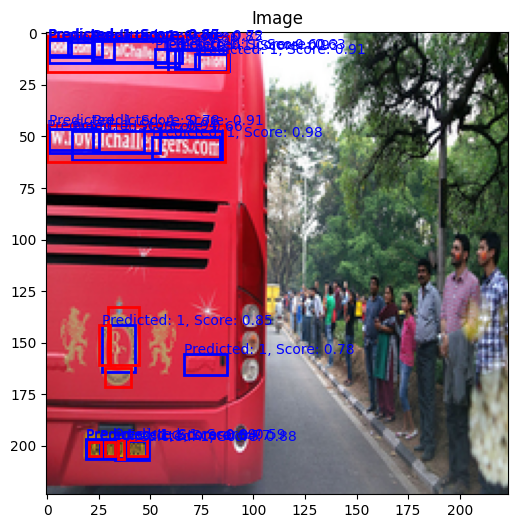

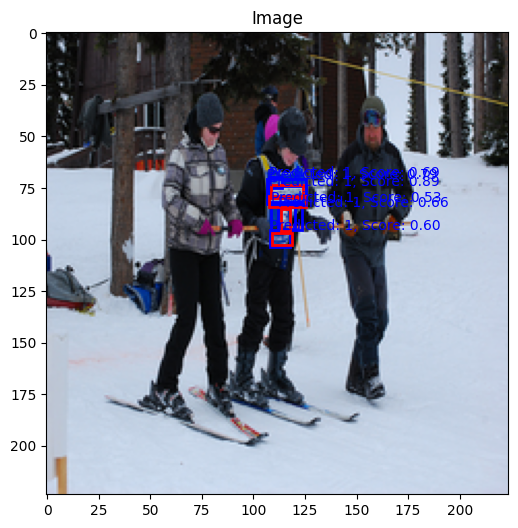

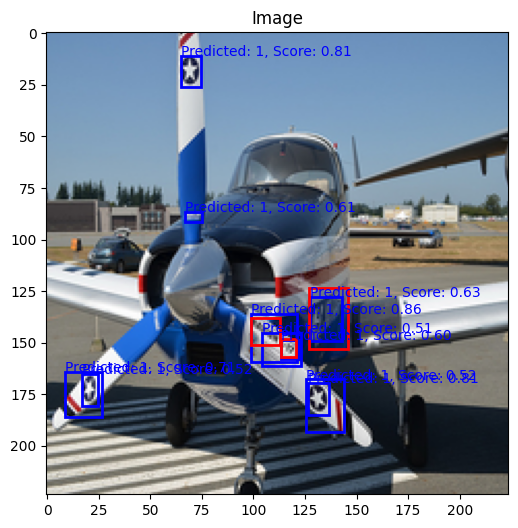

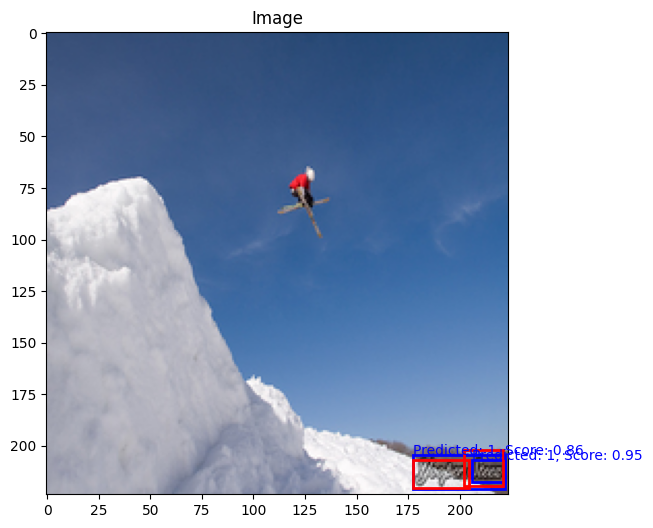

Epoch [1/5] Iteration [0/547] Loss: 0.5848
Epoch [1/5] Iteration [10/547] Loss: 0.5547
Epoch [1/5] Iteration [20/547] Loss: 0.5015
Epoch [1/5] Iteration [30/547] Loss: 0.4908
Epoch [1/5] Iteration [40/547] Loss: 0.5584
Epoch [1/5] Iteration [50/547] Loss: 0.7632
Epoch [1/5] Iteration [60/547] Loss: 0.5488
Epoch [1/5] Iteration [70/547] Loss: 0.5503
Epoch [1/5] Iteration [80/547] Loss: 0.4462
Epoch [1/5] Iteration [90/547] Loss: 0.3452
Epoch [1/5] Iteration [100/547] Loss: 0.6696
Epoch [1/5] Iteration [110/547] Loss: 0.4422
Epoch [1/5] Iteration [120/547] Loss: 0.5086
Epoch [1/5] Iteration [130/547] Loss: 0.5206
Epoch [1/5] Iteration [140/547] Loss: 0.5097
Epoch [1/5] Iteration [150/547] Loss: 0.6259
Epoch [1/5] Iteration [160/547] Loss: 0.6027
Epoch [1/5] Iteration [170/547] Loss: 0.5541
Epoch [1/5] Iteration [180/547] Loss: 0.4787
Epoch [1/5] Iteration [190/547] Loss: 0.6088
Epoch [1/5] Iteration [200/547] Loss: 0.5174
Epoch [1/5] Iteration [210/547] Loss: 0.6335
Epoch [1/5] Iteration

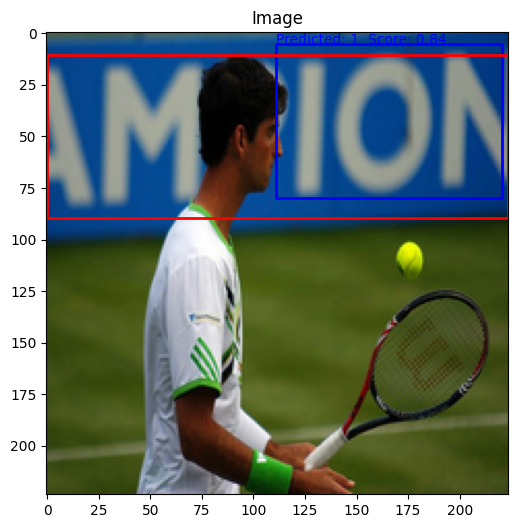

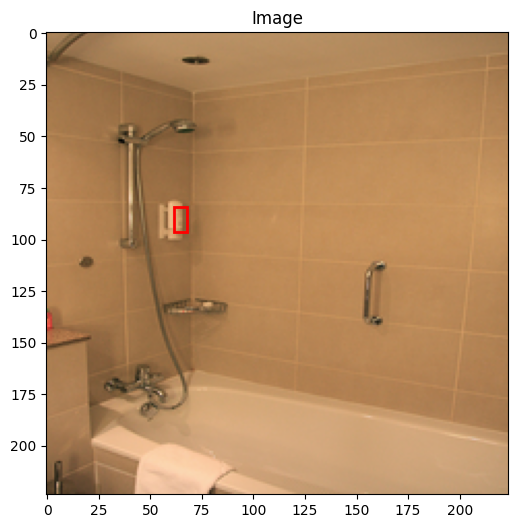

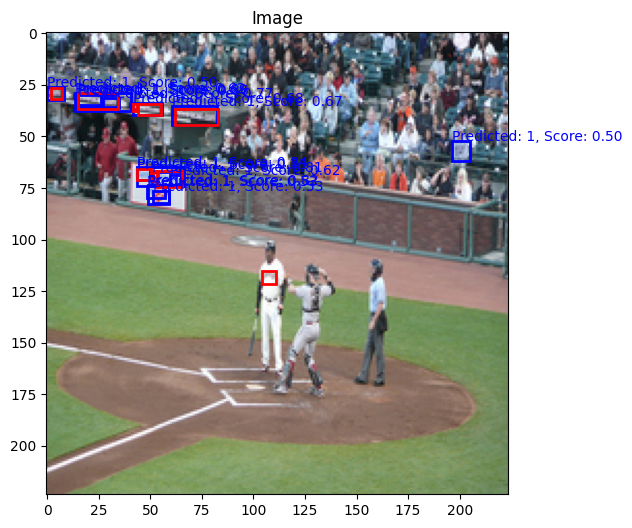

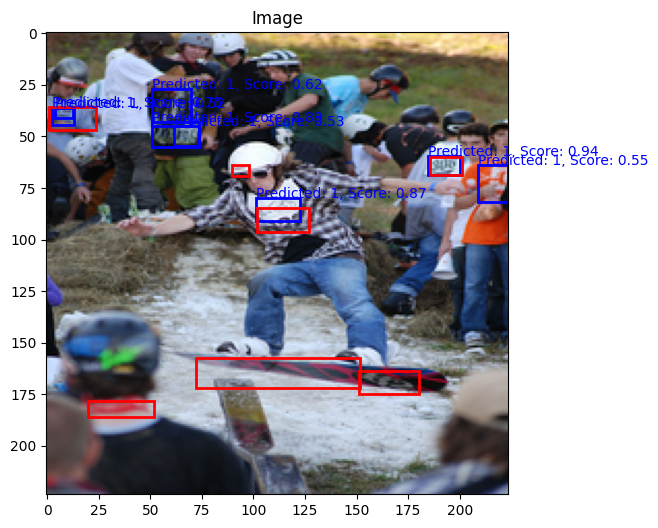

Epoch [2/5] Iteration [0/547] Loss: 0.4199
Epoch [2/5] Iteration [10/547] Loss: 0.5981
Epoch [2/5] Iteration [20/547] Loss: 0.5621
Epoch [2/5] Iteration [30/547] Loss: 0.5976
Epoch [2/5] Iteration [40/547] Loss: 0.4983
Epoch [2/5] Iteration [50/547] Loss: 0.6599
Epoch [2/5] Iteration [60/547] Loss: 0.4112
Epoch [2/5] Iteration [70/547] Loss: 0.4912
Epoch [2/5] Iteration [80/547] Loss: 0.6126
Epoch [2/5] Iteration [90/547] Loss: 0.4001
Epoch [2/5] Iteration [100/547] Loss: 0.4064
Epoch [2/5] Iteration [110/547] Loss: 0.5108
Epoch [2/5] Iteration [120/547] Loss: 0.6285
Epoch [2/5] Iteration [130/547] Loss: 0.6146
Epoch [2/5] Iteration [140/547] Loss: 0.5337
Epoch [2/5] Iteration [150/547] Loss: 0.4841
Epoch [2/5] Iteration [160/547] Loss: 0.3928
Epoch [2/5] Iteration [170/547] Loss: 0.5010
Epoch [2/5] Iteration [180/547] Loss: 0.4141
Epoch [2/5] Iteration [190/547] Loss: 0.9136
Epoch [2/5] Iteration [200/547] Loss: 0.5247
Epoch [2/5] Iteration [210/547] Loss: 0.6411
Epoch [2/5] Iteration

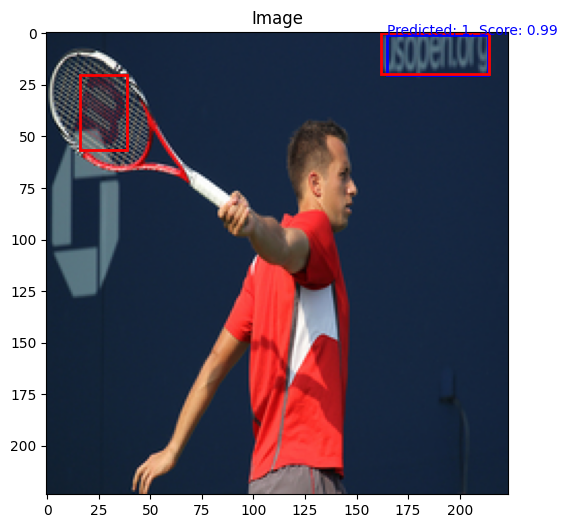

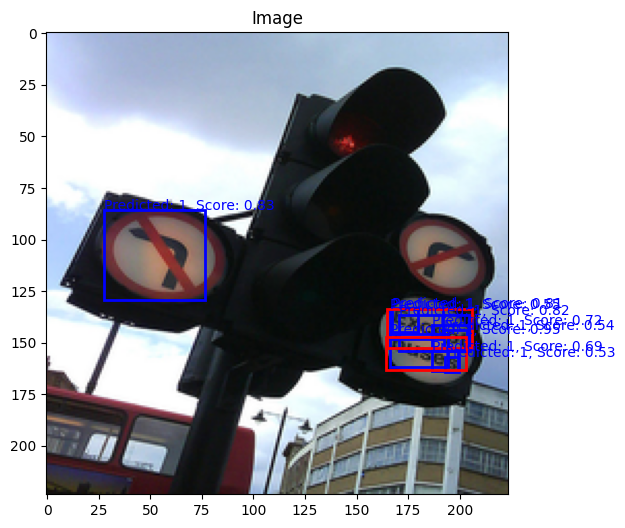

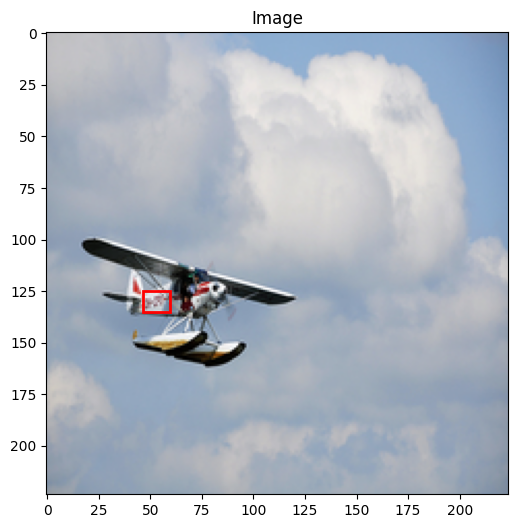

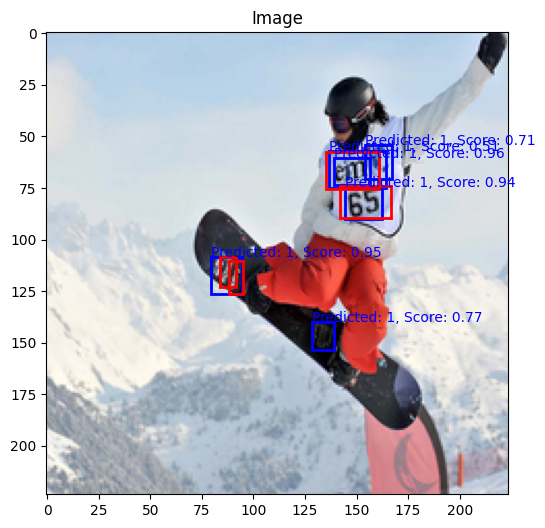

Epoch [3/5] Iteration [0/547] Loss: 0.5046
Epoch [3/5] Iteration [10/547] Loss: 0.4001
Epoch [3/5] Iteration [20/547] Loss: 0.5217
Epoch [3/5] Iteration [30/547] Loss: 0.4354
Epoch [3/5] Iteration [40/547] Loss: 0.5861
Epoch [3/5] Iteration [50/547] Loss: 0.4180
Epoch [3/5] Iteration [60/547] Loss: 0.5764
Epoch [3/5] Iteration [70/547] Loss: 0.5336
Epoch [3/5] Iteration [80/547] Loss: 0.5424
Epoch [3/5] Iteration [90/547] Loss: 0.4885
Epoch [3/5] Iteration [100/547] Loss: 0.4918
Epoch [3/5] Iteration [110/547] Loss: 0.3815
Epoch [3/5] Iteration [120/547] Loss: 0.6303
Epoch [3/5] Iteration [130/547] Loss: 0.4820
Epoch [3/5] Iteration [140/547] Loss: 0.3342
Epoch [3/5] Iteration [150/547] Loss: 0.3706
Epoch [3/5] Iteration [160/547] Loss: 0.4129
Epoch [3/5] Iteration [170/547] Loss: 0.4816
Epoch [3/5] Iteration [180/547] Loss: 0.6038
Epoch [3/5] Iteration [190/547] Loss: 0.5062
Epoch [3/5] Iteration [200/547] Loss: 0.5731
Epoch [3/5] Iteration [210/547] Loss: 0.4499
Epoch [3/5] Iteration

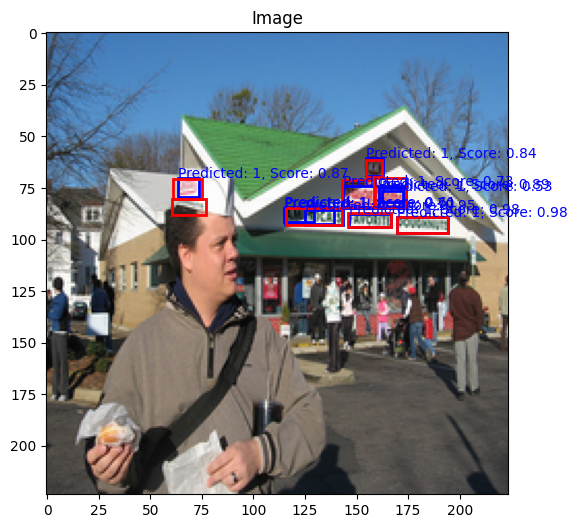

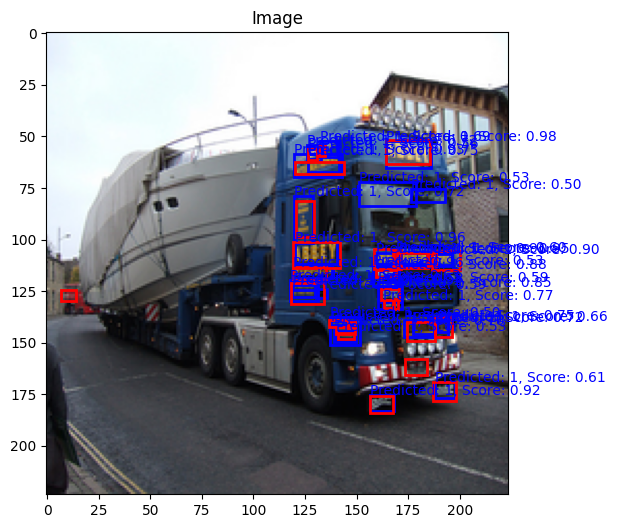

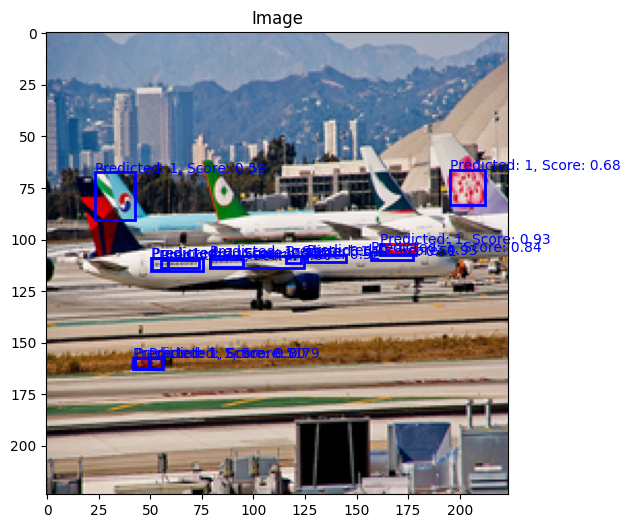

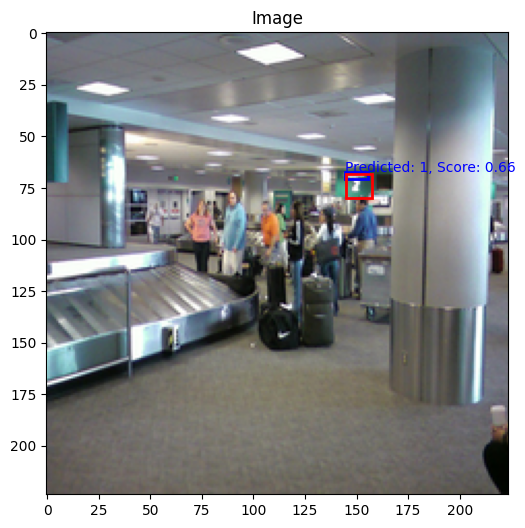

Epoch [4/5] Iteration [0/547] Loss: 0.5003
Epoch [4/5] Iteration [10/547] Loss: 0.4517
Epoch [4/5] Iteration [20/547] Loss: 0.6304
Epoch [4/5] Iteration [30/547] Loss: 0.4931
Epoch [4/5] Iteration [40/547] Loss: 0.5650
Epoch [4/5] Iteration [50/547] Loss: 0.4259
Epoch [4/5] Iteration [60/547] Loss: 0.4101
Epoch [4/5] Iteration [70/547] Loss: 0.5160
Epoch [4/5] Iteration [80/547] Loss: 0.4239
Epoch [4/5] Iteration [90/547] Loss: 0.5864
Epoch [4/5] Iteration [100/547] Loss: 0.6782
Epoch [4/5] Iteration [110/547] Loss: 0.6607
Epoch [4/5] Iteration [120/547] Loss: 0.6335
Epoch [4/5] Iteration [130/547] Loss: 0.4883
Epoch [4/5] Iteration [140/547] Loss: 0.4934
Epoch [4/5] Iteration [150/547] Loss: 0.5843
Epoch [4/5] Iteration [160/547] Loss: 0.3466
Epoch [4/5] Iteration [170/547] Loss: 0.6708
Epoch [4/5] Iteration [180/547] Loss: 0.3429
Epoch [4/5] Iteration [190/547] Loss: 0.5216
Epoch [4/5] Iteration [200/547] Loss: 0.4479
Epoch [4/5] Iteration [210/547] Loss: 0.3842
Epoch [4/5] Iteration

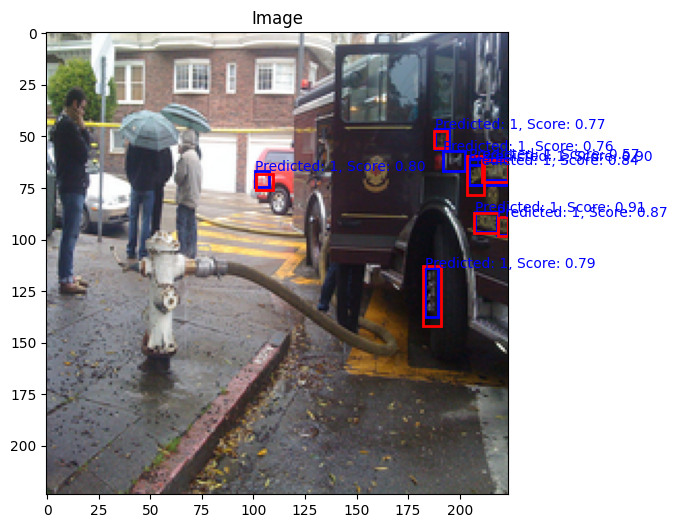

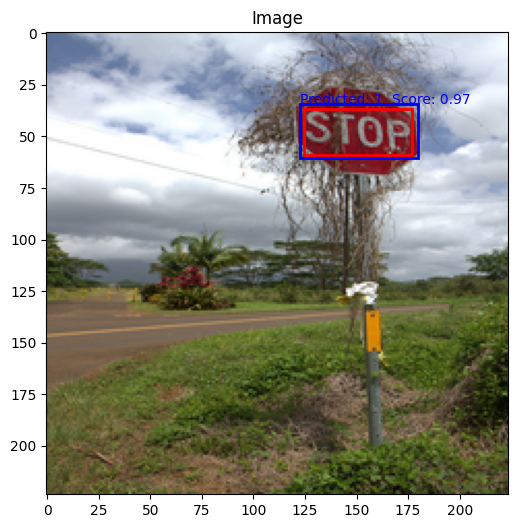

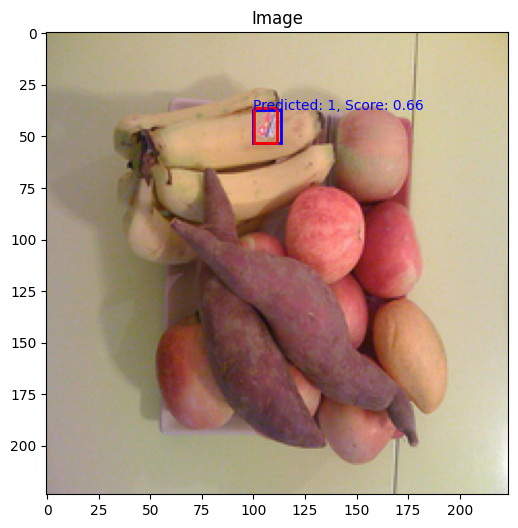

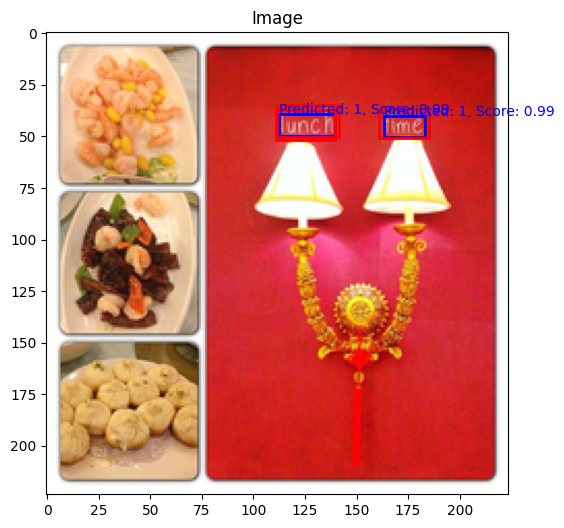

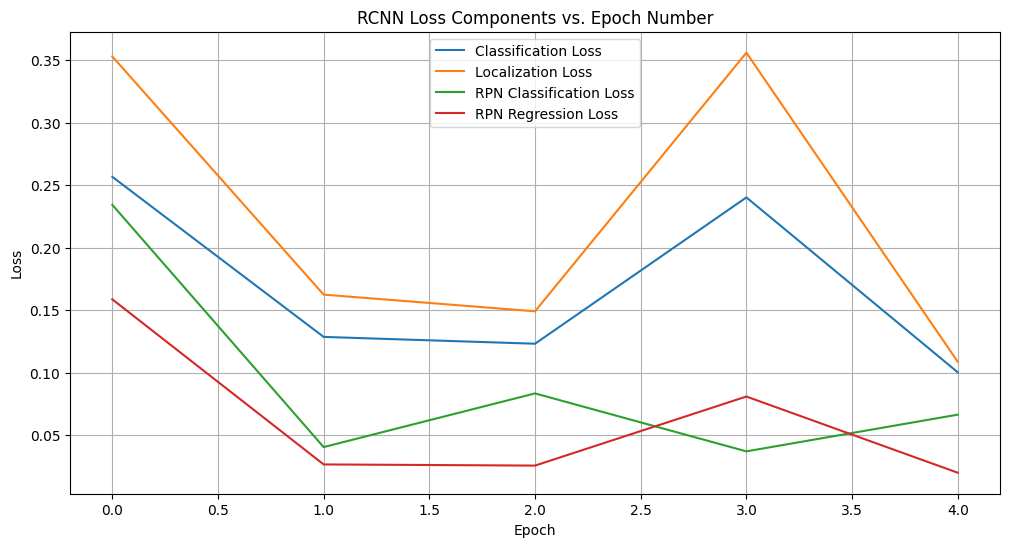

In [ ]:
import torch.optim as optim
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

# Define an optimizer and learning rate scheduler
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 5

# Lists to store loss components
classification_losses = []
localization_losses = []
rpn_classification_losses = []
rpn_regression_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0  # Accumulator for total loss

    for idx, data in enumerate(dataloader):
        # Send data to the device
        images, targets = data
        images = [image.to(device) for image in images]

        # Create a list of dictionaries for targets
        target_list = []
        for target in targets:
            target_dict = {
                "boxes": target["boxes"].to(device),  # Use the correct key "boxes"
                "labels": torch.ones(target["boxes"].shape[0], dtype=torch.int64).to(device),
                "image_id": target["image_id"],  # Assign img_id directly without .to(device)
            }
            target_list.append(target_dict)

        # Zero out gradients
        optimizer.zero_grad()

        # Forward pass and compute loss
        loss_dict = model(images, target_list)
        loss = sum(loss for loss in loss_dict.values())
        total_loss += loss.item()

        # Backpropagation
        loss.backward()

        # Update model weights
        optimizer.step()

        # Print loss after a certain number of iterations (optional)
        if idx % 10 == 0:
            print(f"Epoch [{epoch}/{num_epochs}] Iteration [{idx}/{len(dataloader)}] Loss: {loss.item():.4f}")

    # Update learning rate
    scheduler.step()

    # Calculate and print average loss for the epoch
    avg_loss = total_loss / len(dataloader)
    print(f"Epoch [{epoch}/{num_epochs}] Average Loss: {avg_loss:.4f}")

    # Checkpoint model and optimizer (optional)
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': avg_loss,
    }, f"checkpoint_epoch_{epoch}.pth")

    # VALIDATE
    model.eval()
    evaluate(model, dataloader, device, epoch)

    # Store loss components
    classification_losses.append(loss_dict["loss_classifier"].item())
    localization_losses.append(loss_dict["loss_box_reg"].item())
    rpn_classification_losses.append(loss_dict["loss_objectness"].item())
    rpn_regression_losses.append(loss_dict["loss_rpn_box_reg"].item())

# Plotting the loss components
epochs = range(num_epochs)
plt.figure(figsize=(12, 6))
plt.plot(epochs, classification_losses, label="Classification Loss")
plt.plot(epochs, localization_losses, label="Localization Loss")
plt.plot(epochs, rpn_classification_losses, label="RPN Classification Loss")
plt.plot(epochs, rpn_regression_losses, label="RPN Regression Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("RCNN Loss Components vs. Epoch Number")
plt.grid(True)
plt.show()